# Basketball Fantasy League Recommender System

This Jupyter notebook is part of a comprehensive educational project that demonstrates the integration of data engineering and machine learning concepts. The project showcases three key components: API development, ETL (Extract, Transform, Load) processes, and recommender systems. Specifically, we leverage a custom-built BasketballAPI that generates fictional basketball player data and statistics across multiple seasons by simulating the `nba_api` which is an API Client for www.nba.com. This data is then processed through a Python-based ETL pipeline that cleanly transforms and stores the information in a CSV format. Ultimately, we use different type of recommender systems to solve a fictional fantasy league problem.

The project follows the CRISP-DM (Cross-Industry Standard Process for Data Mining) methodology, which provides a structured approach through six key phases:
1. **Business Understanding**: Defining the need for a fantasy basketball recommender system
2. **Data Understanding**: Analyzing the BasketballAPI data structure and statistical patterns
3. **Data Preparation**: ETL processes to clean and transform the raw API data
4. **Modeling**: Implementing various recommender system algorithms
5. **Evaluation**: Testing the recommendations' accuracy and relevance
6. **Deployment**: Creating a usable system for fantasy basketball managers

While the project encompasses multiple technical aspects, this notebook primarily focuses on building and evaluating different recommender system techniques to suggest similar players based on their statistical performance and characteristics. This practical approach allows us to explore real-world applications of data science while working with a controlled, yet realistic dataset that simulates five seasons of basketball data across 390 players and multiple teams.

### Import Modules - Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from FantasySVD import svd_approach
from FantasyRF import FantasyRecommenderRF
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from BasicRec import FantasyReccomenderBasic
from FantasyAdvanced import FantasyRecommenderAdvanced
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 800)
%matplotlib inline

In [2]:
df = pd.read_csv('basketball_data.csv')

### Exploratory Data Analysis (EDA)

In [3]:
df.head()

,player_id,player_name,archetype,season,team,games_played,minutes,points,rebounds,assists,steals,blocks,fg_pct,fg3_pct,ft_pct
0,0,Robert Smith,regular,2019-20,SkyBirds,55,36.3,5.4,3.9,NaN,1.2,0.2,0.400,0.302,0.709
1,1,Mandy Evans,regular,2019-20,SparkiFY,38,14.8,17.9,5.9,3.9,1.6,0.5,0.431,0.369,0.734
2,2,Miguel Lee,regular,2019-20,SkyBirds,79,17.2,10.1,7.2,2.5,1.4,1.2,0.432,0.322,0.792
3,3,Ashlee Martin,regular,2019-20,HtmlERS,46,31.6,11.6,7.0,3.5,0.5,1.1,0.474,0.365,0.739
4,4,David Hamilton,regular,2019-20,SparkiFY,37,31.9,8.9,6.4,NaN,1.7,0.8,0.433,0.329,NaN


In [4]:
print(f" The dataframe has {df.shape[0]} records and {df.shape[1]} attributes.")

 The dataframe has 1950 records and 15 attributes.


In [5]:
df.dtypes

player_id         int64
player_name      object
archetype        object
season           object
team             object
games_played      int64
minutes         float64
points          float64
rebounds        float64
assists         float64
steals          float64
blocks          float64
fg_pct          float64
fg3_pct         float64
ft_pct          float64
dtype: object

<p><i>Does this dataframe present duplicate values? </i></p>

In [6]:
print(f"The dataframe should contain {df.player_id.nunique()} unique player")

The dataframe should contain 390 unique player


In [7]:
df.groupby('season')['player_id'].count()

season
2019-20    390
2020-21    390
2021-22    390
2022-23    390
2023-24    390
Name: player_id, dtype: int64

<p> <i> Is the relation player-team unique, or do players change team during the course of five seasons? if they do change, what is the ratio?</p>

In [8]:
players_swapped = df.groupby('player_id')['team']\
    .nunique()\
    .reset_index()\
    .rename(columns={'team': 'unique_teams'})
players_swapped_list = players_swapped[players_swapped['unique_teams']>1]\
                                                 ['player_id'].tolist()


In [9]:
print(
    f"Out of {df.player_id.nunique()} players during the 5 seasons analyzed, "
    f"{len(players_swapped_list)} players changed teams, which is a ratio of "
    f"{len(players_swapped_list) / df.player_id.nunique():.2f}."
)


Out of 390 players during the 5 seasons analyzed, 40 players changed teams, which is a ratio of 0.10.


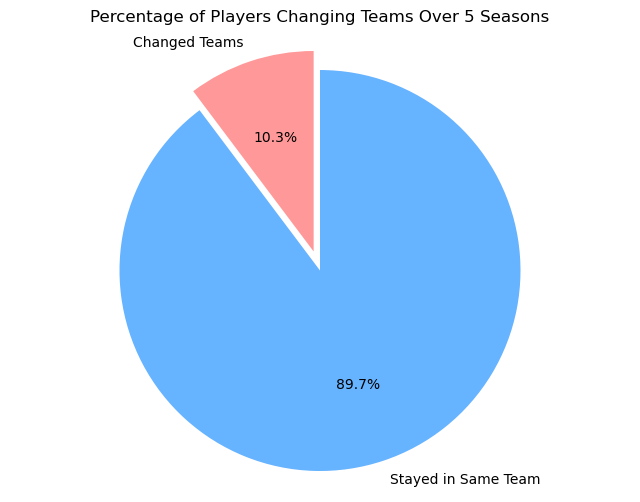

In [10]:

total_players = df.player_id.nunique()
changed_teams = len(players_swapped_list)
unchanged_teams = total_players - changed_teams

# Data for the pie chart
labels = ['Changed Teams', 'Stayed in Same Team']
sizes = [changed_teams, unchanged_teams]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Players Changing Teams Over 5 Seasons')
plt.axis('equal')  
plt.show()


<p> <i>Does the dataframe presents any null values?</i></p>


In [11]:
df.isnull().any()

player_id       False
player_name     False
archetype       False
season          False
team            False
games_played    False
minutes         False
points           True
rebounds         True
assists          True
steals           True
blocks           True
fg_pct           True
fg3_pct          True
ft_pct           True
dtype: bool

In [12]:
print(f" There are {df.isnull().any().sum()} attribues with missing values")

 There are 8 attribues with missing values


In [13]:
#(df.isnull().sum() / df.shape[0])
missing_percentage = (df.isnull().sum() / df.shape[0]) * 100
missing_percentage = missing_percentage[missing_percentage > 0]  
print(missing_percentage)


points      5.435897
rebounds    5.435897
assists     5.538462
steals      4.358974
blocks      4.205128
fg_pct      3.538462
fg3_pct     5.384615
ft_pct      5.230769
dtype: float64


In [14]:
print(f" On average these fields have {round(missing_percentage.mean(),1)}% of missing values")

 On average these fields have 4.9% of missing values


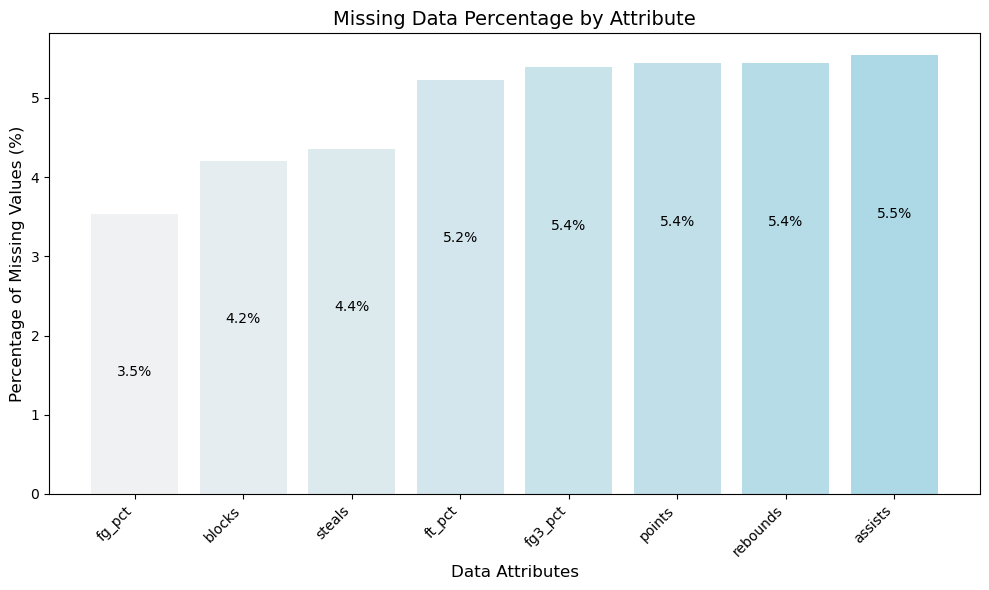

In [15]:
missing_percentage = missing_percentage.sort_values()

# Generate a color palette from light to dark blue
colors = sns.light_palette("lightblue", n_colors=len(missing_percentage))

plt.figure(figsize=(10, 6))
bars = plt.bar(missing_percentage.index, missing_percentage.values, color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height - 2, 
             f'{height:.1f}%', ha='center', va='center', fontsize=10, color='black')

plt.title('Missing Data Percentage by Attribute', fontsize=14)
plt.ylabel('Percentage of Missing Values (%)', fontsize=12)
plt.xlabel('Data Attributes', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()


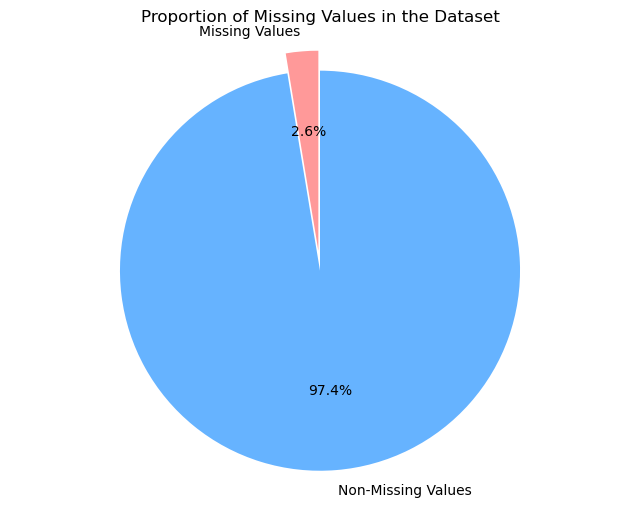

In [16]:

missing_values = df.isnull().sum()
total_missing = missing_values.sum()

# Percentage of missing vs non-missing values
non_missing = df.size - total_missing
sizes = [total_missing, non_missing]
labels = ['Missing Values', 'Non-Missing Values']
colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(8, 6))
plt.pie(
    sizes, 
    labels=labels, 
    colors=colors, 
    autopct='%1.1f%%', 
    startangle=90, 
    explode=(0.1, 0)
)
plt.title('Proportion of Missing Values in the Dataset')
plt.axis('equal')  # Ensures the pie chart is circular
plt.show();


<p>  <i>The data presents missing values in <b>8</b> ot its <b>15</b> attributes with an overall missing value percentage of <b>2.6%</b>. This is something to keep into account as we develop our models. Next we to observe the distributions of some attributes. Now let's look at some summary statics.</i></p>

In [17]:
df.iloc[:,1:].describe()

,games_played,minutes,points,rebounds,assists,steals,blocks,fg_pct,fg3_pct,ft_pct
count,1950.000000,1950.000000,1844.000000,1844.000000,1842.000000,1865.000000,1868.000000,1881.000000,1845.000000,1848.000000
mean,51.735385,25.105949,11.420174,4.495824,3.033659,1.009330,0.641328,0.446874,0.330622,0.752390
std,18.249953,7.595495,5.761876,1.934746,1.938258,0.537009,0.426800,0.048509,0.036472,0.067144
min,20.000000,12.100000,2.000000,1.000000,0.500000,0.000000,0.000000,0.350000,0.250000,0.601000
25%,36.000000,18.400000,7.400000,3.100000,1.700000,0.600000,0.400000,0.413000,0.306000,0.706000
50%,52.000000,25.150000,10.700000,4.200000,2.700000,0.900000,0.500000,0.443000,0.329000,0.748000
75%,68.000000,31.900000,14.400000,5.800000,3.800000,1.300000,0.800000,0.476000,0.354000,0.801000
max,82.000000,38.000000,34.800000,12.000000,11.900000,3.000000,3.000000,0.647000,0.449000,0.947000


<p> <i> The attribute games_played appears to have higher variation. It would be helpful to plot the related histogram.</i></p>

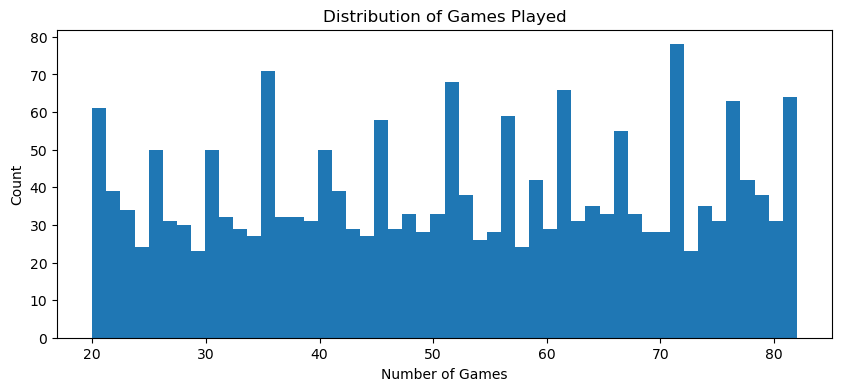

In [18]:
# Create histogram
plt.figure(figsize=(10, 4))
plt.hist(df['games_played'], bins=50)
plt.title('Distribution of Games Played')
plt.xlabel('Number of Games')
plt.ylabel('Count')
plt.show()

<p> <i> A box-plot could help identify any outliers. </i></p>

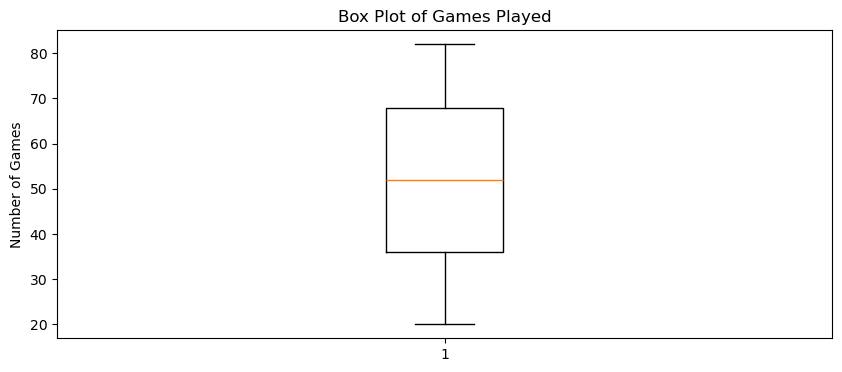

In [19]:
# Create box plot
plt.figure(figsize=(10, 4))
plt.boxplot(df.games_played)
plt.title('Box Plot of Games Played')
plt.ylabel('Number of Games')
plt.show();

<p><i> The box plot of the games_played attribute doesn't present any outliers. Considering the impact of null values and the fact that there is an overall of only <b>2.6%</b> we will proceed to eliminate such values from the dataset used for this project. </i></p>

In [20]:
df = df.dropna(subset=[
        'points', 'rebounds', 'assists', 'steals', 'blocks',
        'fg_pct', 'fg3_pct', 'ft_pct'
    ]).reset_index(drop=True)
df.head()

,player_id,player_name,archetype,season,team,games_played,minutes,points,rebounds,assists,steals,blocks,fg_pct,fg3_pct,ft_pct
0,1,Mandy Evans,regular,2019-20,SparkiFY,38,14.8,17.9,5.9,3.9,1.6,0.5,0.431,0.369,0.734
1,2,Miguel Lee,regular,2019-20,SkyBirds,79,17.2,10.1,7.2,2.5,1.4,1.2,0.432,0.322,0.792
2,3,Ashlee Martin,regular,2019-20,HtmlERS,46,31.6,11.6,7.0,3.5,0.5,1.1,0.474,0.365,0.739
3,5,Anna Thompson,regular,2019-20,HtmlERS,23,19.6,13.6,6.6,4.1,1.2,0.7,0.511,0.330,0.838
4,6,Angela Kelly,regular,2019-20,SkyBirds,41,18.9,10.9,4.9,1.0,0.9,0.3,0.442,0.336,0.781


### Rank-Based Recommendations

In this scenario, we are just getting started with a basketball fantasy league and we have no knowledge of players' interactions from previous fantasy leagues except for player and teams data acquired via API. Thus, a rank-based system (a rule-based recommender) would focus on sorting players according to specific performance metrics and consequent composite score. For the purpose of this project, we can prioritize metrics such as points, rebounds, assists, blocks, and steals, assuming a Head to Head league's scoring system.

In [21]:
# Adding a 'traded' feature: Check if a player changed teams

df['traded'] = df.groupby('player_id')['team'].transform('nunique') > 1


In [22]:
recommender = FantasyReccomenderBasic(df)
top_recommendations = recommender.create_rank_based_recommendations(top_n=10)
print('Top 10 Reccomended Players')
print(top_recommendations)

Top 10 Reccomended Players
   player_id     player_name              team  composite_score  \
0        270  Richard Morris        VBADragons         0.631105   
1        147  Kristen Murphy          SparkiFY         0.616644   
2         39      James Mack         BIsupremE         0.611875   
3        330    Theresa Cook      UnitedWeCode         0.601391   
4        284      Diana Cain           LutammS         0.599319   
5        241     Todd Garcia        VBADragons         0.599099   
6        277   Robert Rivera  KeyBoardWarriors         0.579443   
7        383   Ashley Fisher         BIsupremE         0.569330   
8        321   Melissa Doyle           HtmlERS         0.565963   
9        365    Tracey Blair           HtmlERS         0.564878   

         archetype  traded  
0     elite_scorer   False  
1     elite_scorer   False  
2     elite_scorer   False  
3     elite_scorer   False  
4  elite_playmaker   False  
5     elite_scorer    True  
6  elite_playmaker   False  
7  

In [23]:
coverage = len(top_recommendations) / len(df)
archetype_distribution = top_recommendations['archetype'].value_counts(normalize=True) * 100

elite_count = top_recommendations['archetype'].str.contains('elite').sum()
elite_bias = elite_count / len(top_recommendations) if len(top_recommendations) > 0 else 0
elite_player_count = df[df['archetype'].str.contains('elite')].shape[0]
elite_coverage = elite_count / elite_player_count if elite_player_count > 0 else 0

# Summary Metrics
print(f"Coverage: {coverage}")
print(f"Elite Bias: {elite_bias:.2f}")
print(f"Elite Coverage: {elite_coverage:.2f}")
print("\nArchetype Distribution in Recommendations:")
print(archetype_distribution)

Coverage: 0.007733952049497293
Elite Bias: 1.00
Elite Coverage: 0.05

Archetype Distribution in Recommendations:
archetype
elite_scorer       50.0
elite_playmaker    50.0
Name: proportion, dtype: float64


### Enhanced Rank-Based Recommendations

<i>Builds on the previous system by enabling users to specify both the number of recommended players to return and which players to exclude from the recommendations, based on those already selected by other fantasy league participants.</i>

In [24]:
recommender = FantasyRecommenderAdvanced(df)

# Get recommendations excluding unavailable players
unavailable_players = [270,147,39]
top_recommendations = recommender.create_rank_based_recommendations(unavailable_players=unavailable_players, top_n=10)
print(f"The 10 Recommended players (excluding unavailable players_id {unavailable_players}).")
print(top_recommendations)

The 10 Recommended players (excluding unavailable players_id [270, 147, 39]).
    player_id       player_name              team  composite_score  \
3         330      Theresa Cook      UnitedWeCode         0.601391   
4         284        Diana Cain           LutammS         0.599319   
5         241       Todd Garcia        VBADragons         0.599099   
6         277     Robert Rivera  KeyBoardWarriors         0.579443   
7         383     Ashley Fisher         BIsupremE         0.569330   
8         321     Melissa Doyle           HtmlERS         0.565963   
9         365      Tracey Blair           HtmlERS         0.564878   
10        183      Connor Lopez           HtmlERS         0.561267   
11        174  Nathaniel Vaughn         BIsupremE         0.559483   
12        193         David Kim          SparkiFY         0.557791   

          archetype  traded  
3      elite_scorer   False  
4   elite_playmaker   False  
5      elite_scorer    True  
6   elite_playmaker   False  
7

<p> <i> We can observe that Richard Morris,Kristen Murphy, and James Mack , previosuly ranked as top recomended players, are exluded this time since they have already been selected from another fantasy league player.</i></p>

In [25]:
coverage = len(top_recommendations) / len(df)
archetype_distribution = top_recommendations['archetype'].value_counts(normalize=True) * 100

elite_count = top_recommendations['archetype'].str.contains('elite').sum()
elite_bias = elite_count / len(top_recommendations) if len(top_recommendations) > 0 else 0
elite_player_count = df[df['archetype'].str.contains('elite')].shape[0]
elite_coverage = elite_count / elite_player_count if elite_player_count > 0 else 0

# Summary Metrics
print(f"Coverage: {coverage}")
print(f"Elite Bias: {elite_bias:.2f}")
print(f"Elite Coverage: {elite_coverage:.2f}")
print("\nArchetype Distribution in Recommendations:")
print(archetype_distribution)


Coverage: 0.007733952049497293
Elite Bias: 1.00
Elite Coverage: 0.05

Archetype Distribution in Recommendations:
archetype
elite_playmaker    70.0
elite_scorer       30.0
Name: proportion, dtype: float64


#### Evaluation 
<i>The initial rank-based, rule-based recommender system metrics actually show appropriate behavior for a head-to-head fantasy league recommender. **Coverage (0.007)** is a measure of how many unique players are recommended relative to the entire pool of players; the low value here suggests that the recommender focuses on a very narrow subset of players as requested per user input.In fantasy basketball, you're typically only interested in the most impactful players for your matchups. **Elite Bias (100)** indicates that the system is correctly focusing on elite scorers and playmakers, who typically generate the most fantasy points through multiple categories (points, assists, percentages). **Elite Coverage (0.05)** shows that only 5% of all elite players are included in the recommendations, implying that even within elite categories, the system recommends only a small subset with players who can contribute across multiple statistical categories.

In the archetype distribution, **50% of recommendations are elite_scorer**, while **50% are elite_playmaker**  which makes sense for fantasy basketball where scoring and assist-heavy players typically provide the highest fantasy value as they often contribute in multiple categories (points, FG%, FT%, assists) which is crucial for head-to-head points leagues. Overall, the recommender excels at ranking a small, specific subset of players based on user-defined criteria but has room for improvement in diversifying recommendations to increase both coverage and elite representation.

The enhanced version allows the recommender to exclude unavailable players, the system maintains a Coverage of 0.007, indicating that recommendations remain focused on a small subset of players. The Elite Bias stays at 1, maintaining an emphasis on elite archetypes. However, Elite Coverage remains at 0.05, meaning the inclusion of elite players is still limited. The archetype distribution now favors lite_playmaker **(70%)** with elite_scorer(**30%**) showing that the system is adapting after some elite players were selected.This update improves user control but further narrows the recommender's scope.
</i>

### Collaborative Filtering (Matrix Factorization) using SVD (Singular Value Decomposition)
In this approach, we will combine the rule-based approach from before with SVD (Singular Value Decomposition) to perform collaborative filtering and make player recommendations. We'll treat the recommendation problem as one where we want the system to suggest players who are similar to the one provided by user input. Top reccomended players will be also based on historical performance.
The SVD-based approach uses machine learning techniques to identify latent features in the data, capturing relationships that are not directly observable. This allows for more nuanced recommendations as it combines multiple performance metrics into lower-dimensional representations.

In contrast, the rank-based rule-based approach depends on explicit thresholds or ranking rules for each metric (e.g., top scorers or rebounders). While simpler, it fails to capture complex patterns or interdependencies between metrics.

The SVD-based approach is dynamic and scalable, making it better suited for large datasets where performance metrics interact in complex ways. The rule-based approach is better for explainability and simplicity in smaller datasets.


In [26]:
# # Loop over player_id values in the dataset
# for players_id in df['player_id'].unique(): 
#     if len(df[df['player_id'] == players_id]['archetype'].unique()) > 1:
#         # Print the player_name for the given player_id
#         player_name = df[df['player_id'] == players_id]['player_name'].iloc[0]
#         print(f"Player {player_name} (ID: {players_id}) has more than one archetype.")
    


In [54]:
df[df['archetype']!='regular']['player_id'].unique()

array([ 17,  24,  39,  52,  71,  74,  79,  81,  82,  85,  93, 106, 111,
       116, 131, 147, 158, 181, 183, 186, 187, 193, 205, 221, 241, 254,
       270, 277, 278, 284, 315, 323, 325, 330, 333, 365, 366, 372, 383,
        51,  68, 125, 170, 171, 174, 285, 288, 294, 298, 321, 348, 359,
       119, 387, 198, 305, 354])

In [58]:
player_id = 39

# providing the capability to exlcude some users 
unavailable_players = []
if unavailable_players:
    revised_df = df[~df['player_id'].isin(unavailable_players)]
else:
    revised_df = df.copy()

# Generate matrices
svd_matrix, cosine_sim, player_performance_matrix = svd_approach.svd_augmentated(revised_df)

# Recommend players
recommended_players = svd_approach.recommend_players(player_id, cosine_sim, player_performance_matrix)
recommended_player_details = df[df['player_id'].isin(recommended_players)][['player_id', 'player_name', 'archetype']].drop_duplicates().reset_index(drop=True)
print(f"Top 5 recommended players similar to Player ID {player_id} are:\n", recommended_player_details)

print('\n')
precision_at_k = svd_approach.precisionK(player_id, df, cosine_sim, player_performance_matrix, top_n=5)
print(f"Precision@K for Player ID {player_id}: {precision_at_k}%")

Top 5 recommended players similar to Player ID 39 are:
    player_id       player_name     archetype
0         86    Lacey Peterson       regular
1        158     Robert Warner  elite_scorer
2        200     Sharon Durham       regular
3        330      Theresa Cook  elite_scorer
4        224  Danielle Jackson       regular


Precision@K for Player ID 39: 40.0%


#### Evaluation
<i>We can assess the quality of our recommendations using the Precision at K (P@K) metric. In essence, this metric helps us determining how many of the top K recommended players are relevant. For example, if I'm requesting a list of players similar to Player A, and Player A belongs to the 'elite' archetype, I would expect the recommended players to also be elite, or at least predominantly elite. Conversely, if a player is regular I would expect that recommendations are good if they are either elite or regular. The underlying assumption here is that when looking for similar players based on performance metrics, the archetype plays a key role. If the performance metrics driving the recommendations align with what defines an elite player, it is reasonable to expect that the most similar players will also be elite. Additionally, we can look at the distribution of the precision ranking for each player and have a better understanding.</i>

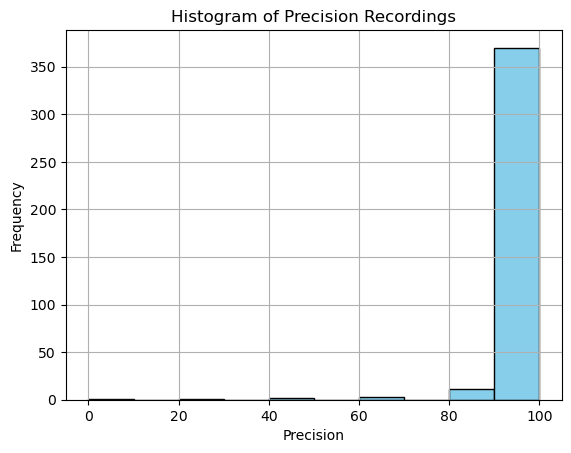

In [40]:
svd_matrix, cosine_sim, player_performance_matrix = svd_approach.svd_augmentated(df)
precisions_recordings = []
unavailable_players=[]
for player_id in df['player_id'].unique():
    try:
        # Handle unavailable players
        if player_id in unavailable_players:
            continue 

        # Calculate precision@K
        precision_at_k = svd_approach.precisionK(
            player_id=player_id,
            df=df,
            cosine_sim=cosine_sim,
            player_performance_matrix=player_performance_matrix,
            top_n=5
        )
        precisions_recordings.append(precision_at_k)

    except Exception as e:
        print(f"Error processing player_id {player_id}: {e}")
        pass


precision_df = pd.DataFrame(precisions_recordings, columns=["Precision"])

precision_df.Precision.hist(bins=10, color='skyblue', edgecolor='black')
plt.xlabel("Precision")
plt.ylabel("Frequency")
plt.title("Histogram of Precision Recordings")

plt.show();





In [33]:
precision_df.describe()

,Precision
count,388.000000
mean,90.902062
std,8.743292
min,0.000000
25%,90.000000
50%,90.000000
75%,90.000000
max,100.000000


<i>The histogram of precision recordings shows that the recommender system performs exceptionally well for the majority of players. The dominant peak at 100% precision indicates that over 300 players received perfect recommendations, meaning all their top recommendations were relevant. A smaller number of players achieved precision scores between 40% and 90%, with very few cases below 40%. The presence of a few outliers at 0% suggests that the system occasionally fails to provide relevant recommendations for certain players, but these cases are rare.</i>

### Collaborative Filtering using Random Forest

In this approach, we combine the rule-based system with a Random Forest model to perform collaborative filtering and make player recommendations. The goal is to suggest players similar to the one provided by the user input, with recommendations based on both historical performance and other features. The Random Forest model, a type of ensemble learning, creates multiple decision trees and aggregates their results to make more accurate predictions.

Random Forest differs from the previous Singular Value Decomposition (SVD) approach in its technique. Instead of identifying latent features through matrix factorization like SVD, Random Forest focuses on creating multiple decision trees to handle complex relationships and interactions within the data. It captures non-linear patterns, making it highly effective for problems where features interact in intricate ways.

While the SVD-based approach breaks down the data into lower-dimensional latent features, the Random Forest approach works by building decision trees that improve over time with more data. It is more flexible and robust when dealing with noisy or highly varied data and performs well in cases where traditional matrix factorization methods might struggle.

Compared to the rank-based rule-based approach, Random Forest offers more predictive power, especially in large and complex datasets, where interactions between features need to be captured. The rule-based method, while easier to explain and implement, does not account for the complexities and interdependencies that a Random Forest model can uncover.

In [59]:

from FantasyRF import FantasyRecommenderRF
fantasy_rec = FantasyRecommenderRF(df)
player_id = 39

# Get initial recommendations (before excluding unavailable players)
initial_recommendations = fantasy_rec.get_recommendations(player_id, top_n=5)
print(f"Top 5 recommended players similar to player_id {player_id}")
print(initial_recommendations[['player_id', 'player_name', 'team', 'archetype']])


precision_initial = fantasy_rec.precisionK(player_id, initial_recommendations)


print(f"\nPrecision at K for initial recommendations for player_id {player_id}: {precision_initial:.2f}%")

# Update unavailable_players set
unavailable_players = [305,39,125]
fantasy_rec.update_unavailable_players(unavailable_players)

updated_recommendations = fantasy_rec.get_recommendations(player_id, top_n=5)


print(f"\nTop 5 recommendations similar to {player_id} excluding unavailable players:")
print(updated_recommendations[['player_id', 'player_name', 'team', 'archetype']])

precision_updated = fantasy_rec.precisionK(player_id, updated_recommendations)

print(f"\nPrecision at K for updated recommendations (excluding unavailable players) for player_id {player_id}: {precision_updated:.2f}%")


Top 5 recommended players similar to player_id 39
     player_id     player_name              team     archetype
325        305      John Gomez        VBADragons  elite_scorer
197        183    Connor Lopez           HtmlERS  elite_scorer
134        125     Anna Curtis        VBADragons  elite_scorer
356        333     Sean Wilson      UnitedWeCode  elite_scorer
304        285  April Hamilton  KeyBoardWarriors  elite_scorer

Precision at K for initial recommendations for player_id 39: 100.00%

Top 5 recommendations similar to 39 excluding unavailable players:
     player_id     player_name              team     archetype
197        183    Connor Lopez           HtmlERS  elite_scorer
356        333     Sean Wilson      UnitedWeCode  elite_scorer
304        285  April Hamilton  KeyBoardWarriors  elite_scorer
259        241     Todd Garcia           HtmlERS  elite_scorer
157        147  Kristen Murphy          SparkiFY  elite_scorer

Precision at K for updated recommendations (excluding u

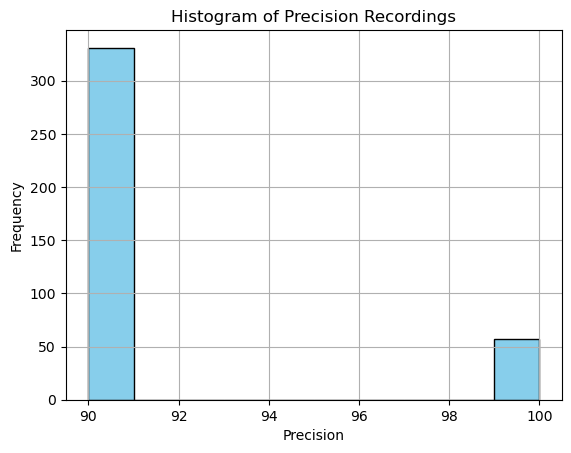

In [42]:
# Initialize the recommender with player data
recommender = FantasyRecommenderRF(df)

# Record precision values
precisions_recordings = []

# List of unavailable players (e.g., players 2 and 4 are unavailable)
unavailable_players = {}

for player_id in df['player_id'].unique():
    try:
        # Handle unavailable players
        if player_id in unavailable_players:
            continue 

        # Get recommendations for the player
        recommendations = recommender.get_recommendations(player_id=player_id, top_n=5)
        
        # Calculate precision at K
        precision_at_k = recommender.precisionK(
            player_id=player_id,
            recommendations=recommendations,
            top_n=5
        )
        precisions_recordings.append(precision_at_k)

    except Exception as e:
        print(f"Error processing player_id {player_id}: {e}")
        pass

# Create a DataFrame for precision recordings
precision_df = pd.DataFrame(precisions_recordings, columns=["Precision"])

# Plot histogram of precision values
precision_df.Precision.hist(bins=10, color='skyblue', edgecolor='black')
plt.xlabel("Precision")
plt.ylabel("Frequency")
plt.title("Histogram of Precision Recordings")

plt.show()

In [32]:
precision_df.describe()

,Precision
count,388.000000
mean,91.469072
std,3.544705
min,90.000000
25%,90.000000
50%,90.000000
75%,90.000000
max,100.000000
